# Exercise 4, task 1. 
# Implementation of Principal Component Analysis from scratch.

From the title it is obvious that the first thing we will do is take a look at the data we are going to test our algorithm on. It is obvious, right? 🙃

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# read test-data provided in course, put into a nice pandas format
xs = list()
ys = list()
with open("pca_dataset.txt") as f:
    line = f.readline()
    while line:
        x, y = float(str(line).split(" ")[0]), float(str(line).split(" ")[1])
        xs.append(x)
        ys.append(y)
        line = f.readline()
pca_data_pandas = pd.DataFrame({"x": xs, "y": ys})
plt.figure(figsize=(6,6))
plt.plot(pca_data_pandas.x, pca_data_pandas.y, "*r")
plt.show()

<Figure size 600x600 with 1 Axes>

Pretty. Ok, let's write that PCA thing. 

## Our very own PCA class (who needs sklearn, right?) 

In [2]:
import pandas as pd
import numpy as np

class PCA:
    
    def __init__(self, k_comp):
        self._k_comp = k_comp
        self._input_data = np.nan 
        self._input_data_centered = np.nan
        self._input_mean = np.nan
        self._u = np.nan
        self._sing_vals = np.nan
        self._components = np.nan
        self._explained_var = np.nan
        self._data_shape = np.nan
        
    def check_input_ok(self, X, mode="transform"):
        """
        check if input X is of correct shape for transform or reverse transform (depending on mode)
        :param X: input numpy matrix
        :param mode: strin, transform or reverse
        """
        if type(np.array([[1],[2]])) != type(X):
            raise ValueError("Input matrix must be a numpy 2D array")
        if mode == "transform":
            return X.shape[1] == self._data_shape[1]
        elif mode == "reverse":
            return X.shape[1] == self._k_comp
        else:
            raise ValueError("check_input_ok: faulty mode argument")
        
    def fit(self, data):
        """
        fit input dataset by applying SVD on it
        :param data: data matrix (2D) in numpy format. Rows represent observations, columns - variables
        """
        self._input_data = data.copy()
        self._u, self._sing_vals, self._components = np.linalg.svd(self._input_data, full_matrices=True)
        
        self._input_mean = np.mean(self._input_data, axis=0)
        self._input_data_centered = self._input_data - self._input_mean
        self._explained_var = np.sum(self._sing_vals[0:self._k_comp])/np.sum(self._sing_vals)
        self._data_shape = self._input_data.shape
    
    def transform(self, X):
        """
        apply dimensionality reduction to X (a numpy matrix of fitting dimensions
        :param X: numpy matrix to which we apply dimensionality reduction
        """
        if not self.check_input_ok(X, mode="transform"):
            raise ValueError("transform: bad argument. Expected numpy 2D matrix with dims nx"+str(self._data_shape[1])+ " got: " + str(X.shape))
        return np.dot(X-np.mean(X, axis=0), np.transpose(self._components[0:self._k_comp, :]))
    
    def reverse_transform(self, X):
        """
        project data back into original space
        :param X: numpy matrix of fitting dimensions
        """
        if not self.check_input_ok(X, mode="reverse"):
            error = str("reverse_transform: bad argument. Expected numpy 2D matrix with dims nx"+str(self._k_comp) + " got: " + str(X.shape))
            raise ValueError(error)
        return np.dot(X, self._components[0:self._k_comp, :]) + self._input_mean
    
    def fit_transform(self, X):
        """
        A combination of fit and transform functions to allow for easier conversions
        :param X: input 2D numpy matrix
        """
        self.fit(X)
        return self.transform(X)
        



## Testing our class on a simple 2D data

In [3]:
K = 1
pca_1 = PCA(1)
pca_1.fit(pca_data_pandas.to_numpy())

<Figure size 432x288 with 0 Axes>

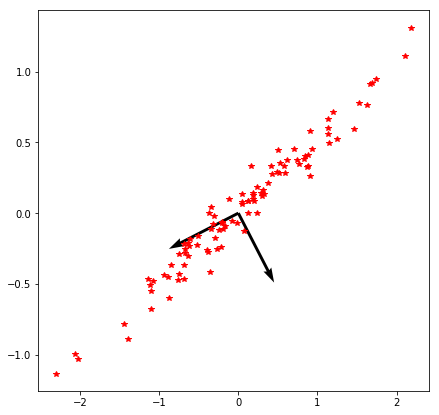

In [4]:
origin = [0], [0]

plt.clf()
plt.figure(figsize=(7,7))
plt.plot(pca_data_pandas.x, pca_data_pandas.y, "*r")
plt.quiver(*origin, pca_1._components[:, 0], pca_1._components[:,1], scale=5)
plt.show()

In [6]:
pca_1._explained_var

0.9226378464433153

That seems fine to me. If we pass to these coordinates and drop one of them (the one that is pointing more to the right), it is believable that we shall lose least information possible. So, let's see what happens to the image.

In [7]:
reduced_dots = pca_1.transform(pca_data_pandas.to_numpy())
recovered_dots = pca_1.reverse_transform(reduced_dots)


<Figure size 432x288 with 0 Axes>

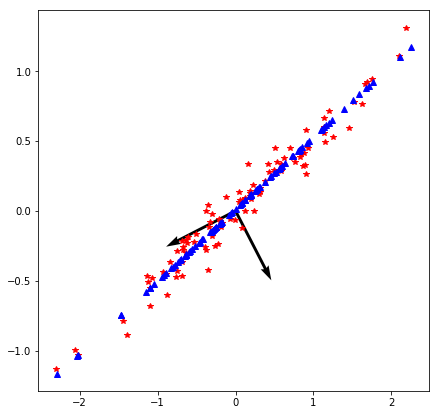

In [8]:
origin = [0], [0]

plt.clf()
plt.figure(figsize=(7,7))
plt.plot(pca_data_pandas.x, pca_data_pandas.y, "*r")
plt.plot(recovered_dots[:,0], recovered_dots[:,1], "^b" )
plt.quiver(*origin, pca_1._components[:, 0], pca_1._components[:,1], scale=5)
plt.show()

## Applying my_PCA to an image
Ok let's get that image.

In [9]:
from scipy import misc

my_image = misc.face()
print("done! The type of variable is : " + str(type(my_image)) + " and the dimensions are: " + str(my_image.shape))

done! The type of variable is : <class 'numpy.ndarray'> and the dimensions are: (768, 1024, 3)


Heeeeey, the dimensions of the array are not as described in the task! And it's not that I am doing something wrong, look: https://docs.scipy.org/doc/scipy/reference/generated/scipy.misc.face.html
It says: "Get a 1024 x 768, color image of a raccoon face".


Anyways, let's take a look at our guy.

<Figure size 432x288 with 0 Axes>

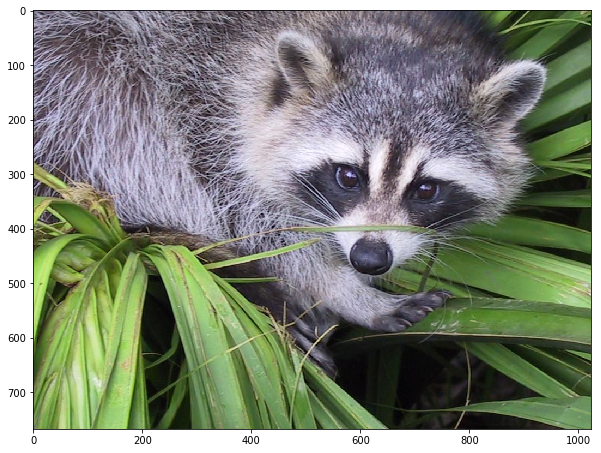

In [10]:
import matplotlib.pyplot as plt
plt.clf()
plt.figure(figsize=(10,10))
plt.imshow(my_image)
plt.show()

There he is 💙 

Now, we get a 3D array as data of shape (768, 1024, 3). The idea is to unravel each row into a 1D array, get a 2D matrix of shape (768, 3072) and pass into our PCA algorithm. Note that we have 3072-dimensional space here (so not really sure what's with the 249 number from the task). We will try projecting this to several lower-dimensional spaces and back in order to see what kind of information loss we are dealing with. We also will to keep track of explained variance (what a handy class we have, huh?).

In [11]:
import numpy as np
import pandas as pd

image_rows = np.array([np.ravel(img_row) for img_row in my_image])
image_df = pd.DataFrame(image_rows)

In [12]:
image_df.shape

(768, 3072)

In [13]:
dims = [500, 250, 125, 70, 50, 35, 15, 10]
images = list()
explained_vars = list()

for dim in dims:
    pca_image = PCA(dim)
    recovered_img =  np.round(pca_image.reverse_transform(pca_image.fit_transform(image_df.to_numpy())).reshape((768, 1024, 3))).astype(int)
    images.append(recovered_img)
    explained_vars.append(pca_image._explained_var)

<Figure size 432x288 with 0 Axes>

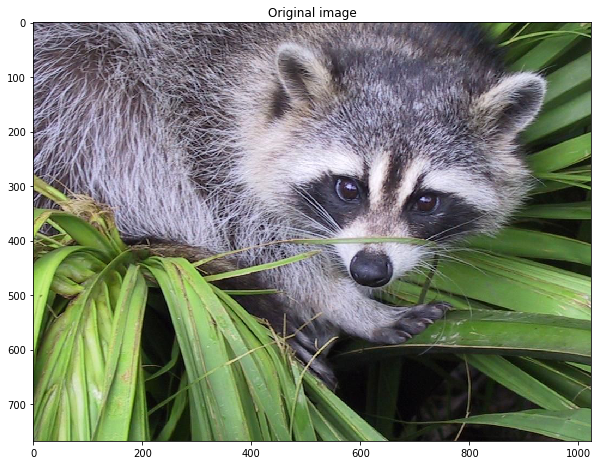

<Figure size 432x288 with 0 Axes>

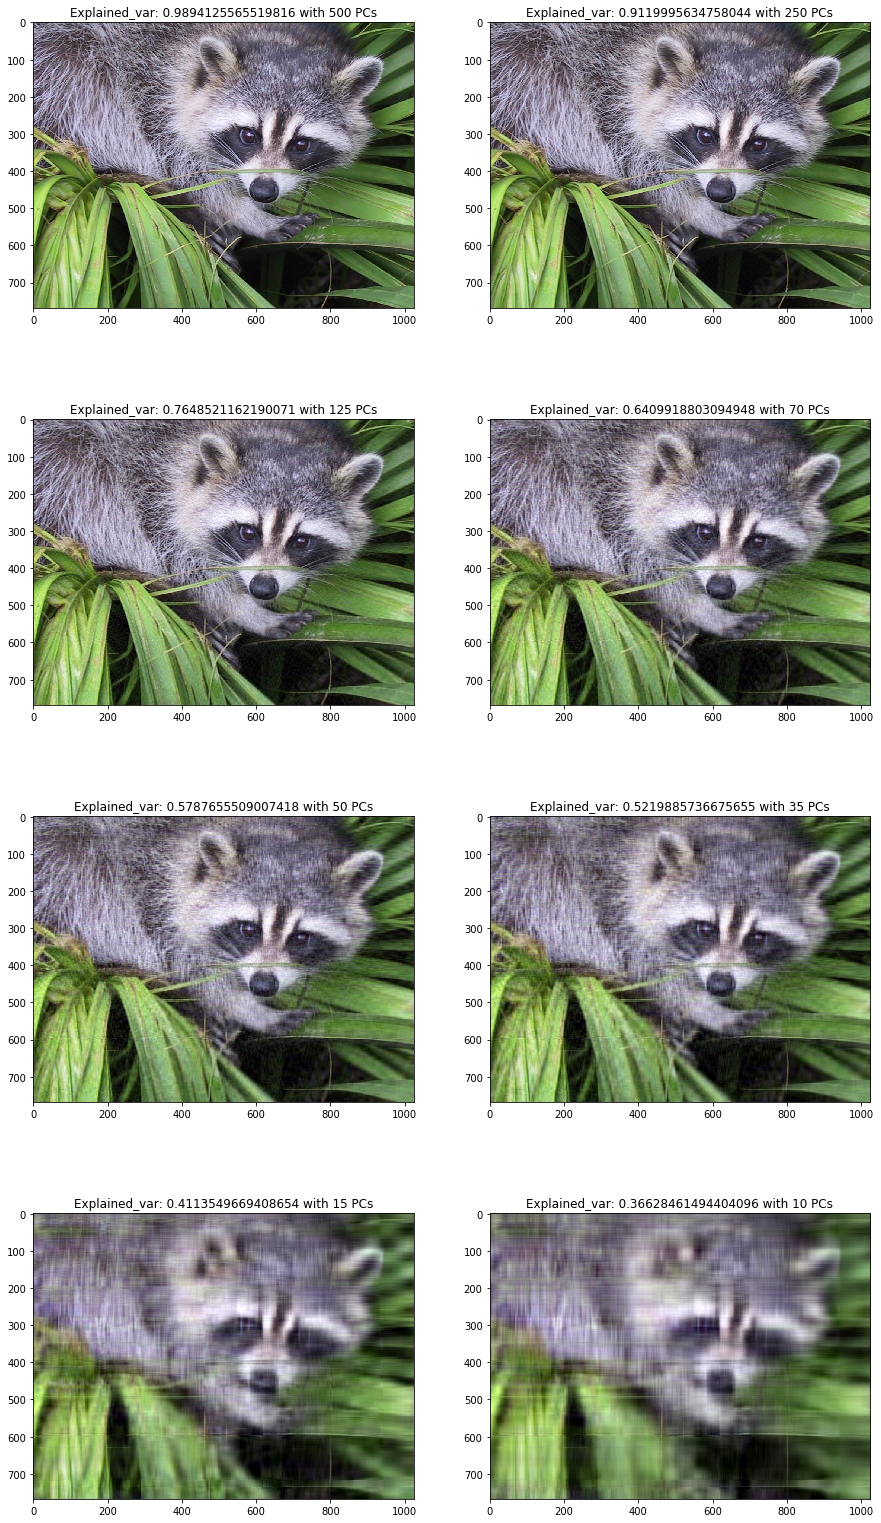

In [14]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import logging

# turning off annoying warnings
logger = logging.getLogger()
old_level = logger.level
logger.setLevel(100)

plt.clf()
plt.figure(figsize=(10,10))
plt.imshow(my_image)
plt.title("Original image")
plt.show()

plt.clf()
fig = plt.figure(figsize=(15,28))
gs = gridspec.GridSpec(nrows=4, ncols=2, height_ratios=[1, 1, 1, 1])

for i in range(len(images)):
    row = int(i / 2)
    col = i%2
    ax0 = fig.add_subplot(gs[row,col])
    ax0.imshow(images[i])
    ax0.set_title("Explained_var: " + str(explained_vars[i]) + " with " + str(dims[i]) + " PCs")
plt.show()

# turning warnings back on
logger.setLevel(old_level)

As we can see, even with 50 PCs that record only 57% of variance information loss is hardly visible. Cool. Let's get to the scenario part now.

## PCA and Vadere scenarios

Let's load the data first.

In [15]:
vadereDF = pd.DataFrame()
with open("data_DMAP_PCA_vadere.txt") as f:
    line = f.readline()
    while line:
        coords = [float(elem) for elem in str(line).split(" ")]
        vadereDF = vadereDF.append(pd.Series(coords), ignore_index=True)
        line = f.readline()

In [16]:
vadereDF.shape

(1000, 30)

In [17]:
vadereDF.head()

0          1          2          3         4          5         6   \
0  7.682746  16.590135  13.483825  16.516303  4.094633  12.947896  6.185209   
1  8.145535  16.648409  13.277208  16.328543  4.044564  12.747607  6.039434   
2  7.887370  16.508989  13.481755  16.028657  3.819413  13.021751  5.865487   
3  7.946284  16.306714  13.712739  16.406934  4.325781  12.930226  5.501616   
4  7.890591  16.154034  13.680053  16.130988  4.193020  13.185905  6.015438   

          7         8          9   ...        20         21        22  \
0  14.051827  2.384750  11.906402  ...  7.618038  14.830008  5.793517   
1  14.420585  2.158819  11.833650  ...  7.307820  14.957749  5.541795   
2  14.156773  1.987087  11.675436  ...  7.386211  14.685901  5.426626   
3  14.330293  1.944104  11.744856  ...  7.323483  14.580033  5.046127   
4  14.806179  1.696377  11.606308  ...  6.681000  14.940958  5.360103   

         23         24         25         26         27        28         29  
0  7.085613  13.165387  18.276296  10.980464  17.096179  5.906016  15.322550  
1  7.212933  13.209182  18.195222  11.202859  17.305462  5.822190  15.679348  
2  7.085823  13.417320  18.207198  11.005363  17.370636  5.552942  15.409457  
3  7.388251  13.822416  18.175465  11.041945  16.840682  5.196317  15.293325  
4  7.249443  13.255405  17.885457  11.012918  17.334755  5.829825  15.386860  

[5 rows x 30 columns]

Ok, looks like we have what we need. Let's visualize the paths of the first two guys. In this case, we need to visualize two plots: column 0 and 1, column 2 and 3

<Figure size 432x288 with 0 Axes>

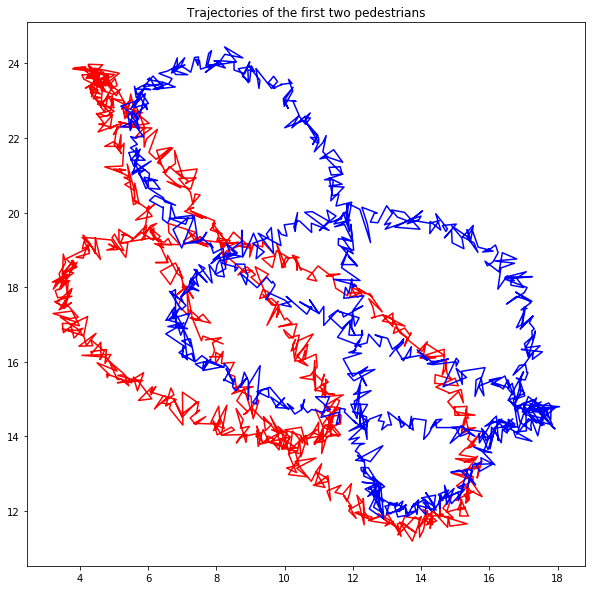

In [18]:
import matplotlib.pyplot as plt

plt.clf()
plt.figure(figsize=(10,10))
plt.plot(vadereDF[0].tolist(), vadereDF[1].tolist(), "r")
plt.plot(vadereDF[2].tolist(), vadereDF[3].tolist(), "b")
plt.title("Trajectories of the first two pedestrians")
plt.show()

Ok I am not entirely sure what this is, but looks  like people are just running in circles or something. Ok, not circles, but cycles. May be the others do, too. Let's to our PCA thing.

In [19]:
pca_vadere = PCA(2)
pca_data_compressed = pca_vadere.fit_transform(vadereDF.to_numpy())

In [20]:
pca_data_compressed.shape

(1000, 2)

In [21]:
pca_vadere._explained_var

0.7688378539531027

Ooh, that's pretty good. We can now visualize the data that was initially 30-dimensional (try to visualize that!) and conserve almost 77% of information. Let's do that!

<Figure size 432x288 with 0 Axes>

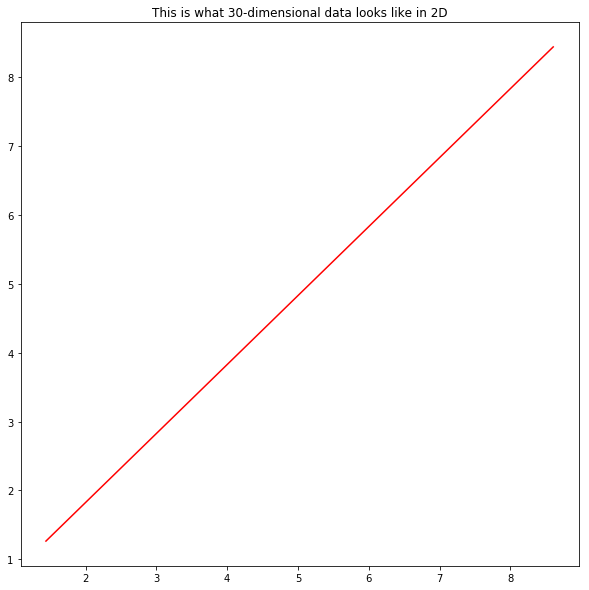

In [22]:
import matplotlib.pyplot as plt

plt.clf()
plt.figure(figsize=(10,10))
plt.plot(pca_data_compressed[0], pca_data_compressed[1], "r")
plt.title("This is what 30-dimensional data looks like in 2D")
plt.show()

Ehm. What. Why is it so straight. We DID capture most of the energy (77% counts as most, right?). 